# Introduction/Abstract

Data set from King County Washington.

# Packages Needed/Setting Global Variables

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# EDA

## Questions about the Data

## Import and Clean the Data

In [68]:
# Import the dataset
df = pd.read_csv('kc_house_data.csv')

# Creating a new column for the year sold, dropping origianl date
df['year_sold'] = df.date.apply(lambda x: x[-4:]).astype(int)
df.drop(['date'], axis=1)

# Changing bedroom number for outlier, I think it was a typo of hitting 3 twice
# based off of the sqft
df.at[15856, 'bedrooms'] = 3

# Replacing NaN values in 'waterfront' with 0
df['waterfront'] = df['waterfront'].fillna(0)

# Replacing NaN values in view with the median/mode value which is 0 (63 entries)
# 0 means house was not viewed
df['view'] = df['view'].fillna(0)

# Replacing ? in sqft_basement and converting to float
df['sqft_basement'] = df['sqft_basement'].replace('?',0).astype(float)

# Replacing 0 for Nan value in year renovated. Maybe make this a categorical value of
# renovated or not?
df['yr_renovated'] = df['yr_renovated'].replace(0,np.nan)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     21597 non-null  float64
 9   view           21597 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  float64
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   744 non-null    float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [93]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,NaN,98178,47.5112,-122.257,1340,5650,2014
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,2014
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062,2015
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,NaN,98136,47.5208,-122.393,1360,5000,2014
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,NaN,98074,47.6168,-122.045,1800,7503,2015


In [92]:
df.sqft_lot15.min()

651

In [43]:
df.loc[df['sqft_above']<400]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold
860,1723049033,6/20/2014,245000.0,1,0.75,380,15000,1.0,0.0,0.0,3,5,380,0.0,1963,0.0,98168,47.4810,-122.323,1170,15000,2014
15367,2856101479,7/1/2014,276000.0,1,0.75,370,1801,1.0,0.0,0.0,5,5,370,0.0,1923,0.0,98117,47.6778,-122.389,1340,5000,2014
21316,9266700190,5/11/2015,245000.0,1,1.00,390,2000,1.0,0.0,0.0,4,6,390,0.0,1920,0.0,98103,47.6938,-122.347,1340,5100,2015


(array([8.3540e+03, 1.0165e+04, 2.5810e+03, 3.9500e+02, 7.2000e+01,
        2.3000e+01, 2.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  370.,  1687.,  3004.,  4321.,  5638.,  6955.,  8272.,  9589.,
        10906., 12223., 13540.]),
 <a list of 10 Patch objects>)

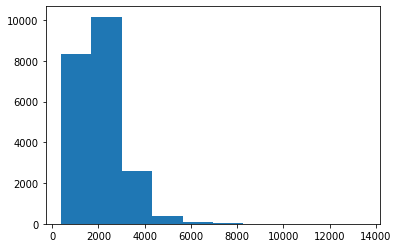

In [88]:
plt.hist(df['sqft_living'])

## Notes

In [7]:
# There is 21 columns, one being the id
categoricals = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition',
                'grade', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long','year_sold']
continuous = ['sqft_living', 'sqft_lot', 'sqft_above',
              'sqft_basement', 'sqft_living15', 'sqft_lot15']

In [ ]:
# Engineer columns like age when sold, maybe do something with the renovation